# Example of Training with MotionSense

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append("..")

## Read Processed Data

In [3]:
from librep.utils.dataset import load_full_data, PandasDatasetsIO

In [4]:
dataset_path = Path("../data/views/MotionSense/balanced_view")
train, validation, test = PandasDatasetsIO(dataset_path).load()

## Create the MotionSense Dataset

In [5]:
from librep.datasets.motionsense import MotionSenseDataset

In [6]:
train_dataset = MotionSenseDataset(
    train,
    sensors=["userAcceleration", "rotationRate"],
    label_columns="activity code",
    as_array=True
)
validation_dataset = MotionSenseDataset(
    validation,
    sensors=["userAcceleration", "rotationRate"],
    label_columns="activity code",
    as_array=True
)
test_dataset = MotionSenseDataset(
    test, sensors=["userAcceleration", "rotationRate"],
    label_columns="activity code",
    as_array=True
)

In [7]:
len(train_dataset)

3318

In [8]:
print(train_dataset[0][0].shape)

(900,)


## Transform using FFT

In [9]:
from librep.transforms.fft import FFT
from librep.utils.transform import TransformDataset, WindowedTransform

fft_transform = FFT()
windowed_fft = WindowedTransform(fft_transform, window_size=300)
transformer = TransformDataset(transforms=[windowed_fft])

In [10]:
train_dataset = transformer(train_dataset)
validation_dataset = transformer(validation_dataset)
test_dataset = transformer(test_dataset)

In [11]:
print(train_dataset[0])

(array([  0.578507  ,   1.17047469,   2.2247307 ,   3.82946018,
         1.89243456,   4.92012634,   2.3256762 ,   4.48563564,
         4.55495607,   6.46228751,   3.26315982,   7.29200139,
        13.64615887,  24.90251322,  25.33374983,   6.84167448,
        12.93846292,   7.15560121,   1.57171136,  10.03125441,
         9.07741181,   5.81770429,  10.97510574,   1.53528844,
        11.7214287 ,   8.15298799,   5.68056337,   1.14001754,
        15.5988168 ,   5.81613078,  12.09041674,   7.19420792,
         3.58583251,   8.81032359,  13.6674213 ,  10.23953044,
         5.69067233,   6.07959614,   4.40435664,   4.01518886,
         7.44766564,  11.20879541,   9.26177689,   5.28440761,
         2.73177379,   9.38063995,   6.2054747 ,   3.52679441,
         3.88950315,   2.21676968,   4.10850276,   4.95074076,
         5.46994413,   6.28508821,  10.32181147,   4.17348632,
         4.58373498,   3.43538693,   4.08989381,   5.71097303,
         5.31304273,   5.3395437 ,   3.8085296 ,   0.7

## Classify using Random Forest

In [12]:
from librep.estimators import RandomForestClassifier
from librep.metrics import classification_report

In [13]:
model = RandomForestClassifier()
model.fit(train_dataset[:][0], train_dataset[:][1])

RandomForestClassifier()

In [14]:
y_pred = model.predict(test_dataset[:][0])

In [15]:
print(classification_report(test_dataset[:][1], y_pred))

              precision    recall  f1-score   support

           0       0.66      0.87      0.75       169
           1       0.75      0.83      0.79       169
           2       0.93      0.76      0.84       169
           3       0.80      0.94      0.86       169
           4       0.96      0.63      0.76       169
           5       0.97      0.89      0.93       169

    accuracy                           0.82      1014
   macro avg       0.84      0.82      0.82      1014
weighted avg       0.84      0.82      0.82      1014



## Visualize Confusion Matrix

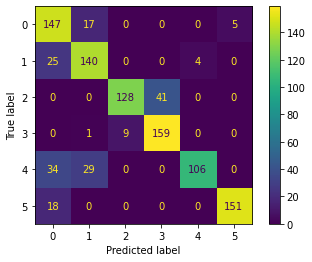

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_dataset[:][1], y_pred)

## Do all of this using a Experiment Helper

In [22]:
from librep.utils.workflow import SimpleTrainEvalWorkflow

experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier(), transforms=[windowed_fft], evaluator=classification_report)
print(experiment(train_dataset, test_dataset))

              precision    recall  f1-score   support

           0       0.91      0.67      0.77       231
           1       0.87      0.84      0.85       176
           2       0.76      0.91      0.83       141
           3       0.93      0.79      0.85       199
           4       0.46      0.85      0.60        92
           5       0.96      0.93      0.95       175

    accuracy                           0.82      1014
   macro avg       0.82      0.83      0.81      1014
weighted avg       0.86      0.82      0.82      1014

